In [1]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy import signal

import pickle
import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

In [2]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

/Users/askebest/Documents/GitHub/Masters


In [3]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[10, 10], N_chirps=1)

## Setting up the target

In [4]:
target_model_1 = mmars.Target(start_position=np.array([[10.001,10.001]]), start_velocity=1., T_total=100., T_frame=0.1)

target_model_1.generate_trajectory(trajectory_type="sinusoidal")

target_ground_truth = target_model_1.get_trajectory()

mrblatcomp = mmars.MRBLaT_Functions_new(radar_model_1, target_model_1)

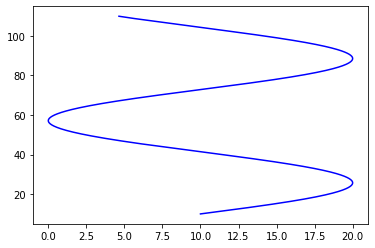

In [5]:
plt.plot(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="blue")

In [6]:
# simulation_data = mmars.MRBLaT_Functions(radar_model_1, target_model_1)

# simulation_data.run()

In [7]:
#sim_data = simulation_data.get_data()


# # pickle data dump
# with open('sim_data.pickle', 'wb') as f:
#     pickle.dump(sim_data, f)

# pickle data load
with open('sim_data.pickle', 'rb') as f:
    sim_data = pickle.load(f)

In [8]:
frame = 200

print(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

max_range = 100
Ns = 3072


# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

radar_model_1.generate_S_signal(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

S_N = radar_model_1.get_S_signal.flatten()[:, np.newaxis]/np.sqrt(256)

19.093974268256744 30.00100000000018


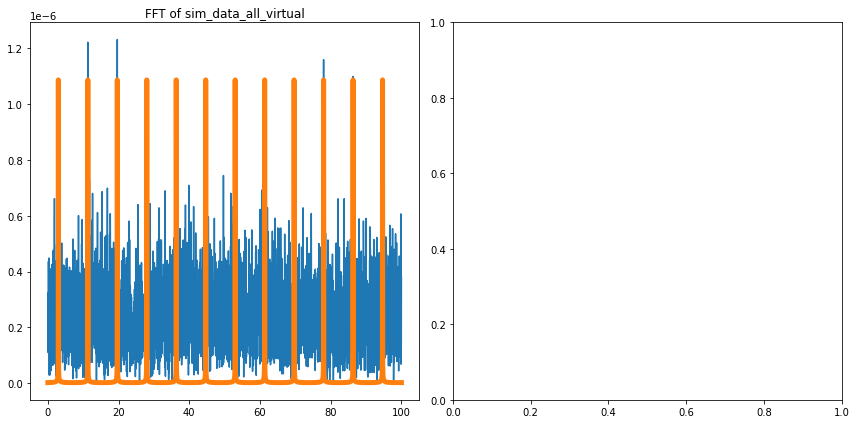

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


#axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T), lw=2)
axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier))
axs[0].plot(np.linspace(0, max_range, Ns), np.abs(S_N), lw=5)


#axs[0].set_xlim([0, 10])
#axs[0].set_xlim([0, 10])
axs[0].set_title('FFT of sim_data_all_virtual')

#axs[1].set_xlim([0, 10])
#axs[1].set_title('Generated S Signal')

plt.tight_layout()
plt.show()

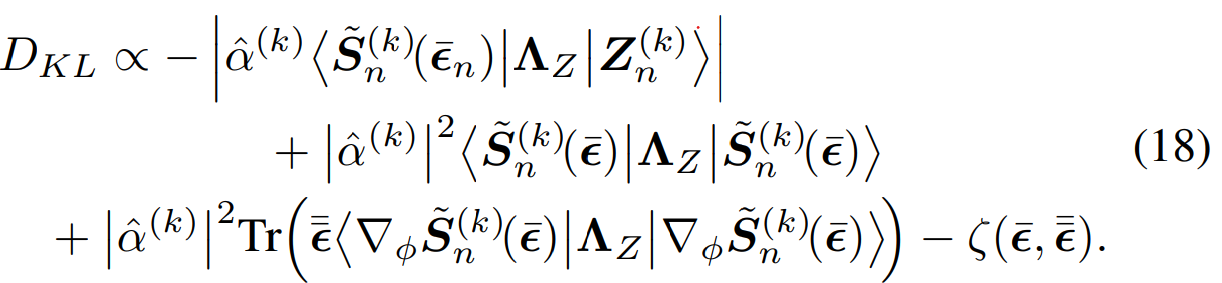

In [10]:
#Lambda_z = np.eye(3072) * (Boltzmann * 290 * 0.77e9)**(-2)
Lambda_z = np.eye(3072) * (radar_model_1.get_standardDeviation)**(-2)
Lambda_z = csr_matrix(Lambda_z)

In [11]:
sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual
data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])
data_fourier_energy = data_fourier.conj().T @ data_fourier
data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

In [14]:
last_frame_x = target_model_1.get_trajectory()[0][frame-1]
last_frame_y = target_model_1.get_trajectory()[1][frame-1]

param = (last_frame_x, last_frame_y, 1, 1)
bound = [(-100,100), (0.1,100), (0.00001, 10), (0.00001, 10)]

input = np.array([target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame], 0.5, 0.5])

result = minimize(mrblatcomp.D_KL, param, bounds = bound,  args=(data_fourier, last_frame_x, last_frame_y, (1,1,1,1), True), method='nelder-mead')
#mrblatcomp.D_KL(input, data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=True)

partial_A_y: [ 0.        +0.j          0.03987714-0.00491343j -0.0195062 -0.07795397j
 -0.11247522+0.04333911j  0.07569113+0.14177483j  0.16431815-0.11557573j
 -0.16176316-0.17874141j -0.18388761+0.21280842j  0.26708421+0.17883798j
  0.16293842-0.32281829j -0.37813446-0.13582027j -0.09741496+0.43109632j]
[[-138.0934357]] [[160.28023061]] [[30.71116115]] 2.8378770664093453
partial_A_y: [ 0.        +0.j          0.03970869-0.00728185j -0.02864966-0.07548787j
 -0.10362311+0.06269371j  0.10714177+0.12082024j  0.12439121-0.15897158j
 -0.21456131-0.11241194j -0.0838447 +0.26987133j  0.32064952+0.0386191j
 -0.02233256-0.36265066j -0.39186032+0.09708779j  0.18279446+0.40471305j]
[[-14.321161]] [[151.14375287]] [[31.09478869]] 2.8378770664093453
partial_A_y: [ 0.        +0.j          0.03789316-0.00243579j -0.00972307-0.07531774j
 -0.11180834+0.02180179j  0.03857222+0.14690603j  0.18016142-0.05989562j
 -0.08559509-0.21113781j -0.23941424+0.11545667j  0.14923063+0.26458838j
  0.28627942-0.186633

In [13]:
print(f"{result}\n{target_ground_truth[0][frame], target_ground_truth[1][frame]}")

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: -8.335782426966151
             x: [ 1.909e+01  3.002e+01  3.446e-02  1.177e-02]
           nit: 284
          nfev: 496
 final_simplex: (array([[ 1.909e+01,  3.002e+01,  3.446e-02,  1.177e-02],
                       [ 1.909e+01,  3.002e+01,  3.446e-02,  1.177e-02],
                       ...,
                       [ 1.909e+01,  3.002e+01,  3.445e-02,  1.176e-02],
                       [ 1.909e+01,  3.002e+01,  3.446e-02,  1.176e-02]]), array([-8.336e+00, -8.336e+00, -8.336e+00, -8.336e+00,
                       -8.336e+00]))
(np.float64(19.093974268256744), np.float64(30.00100000000018))


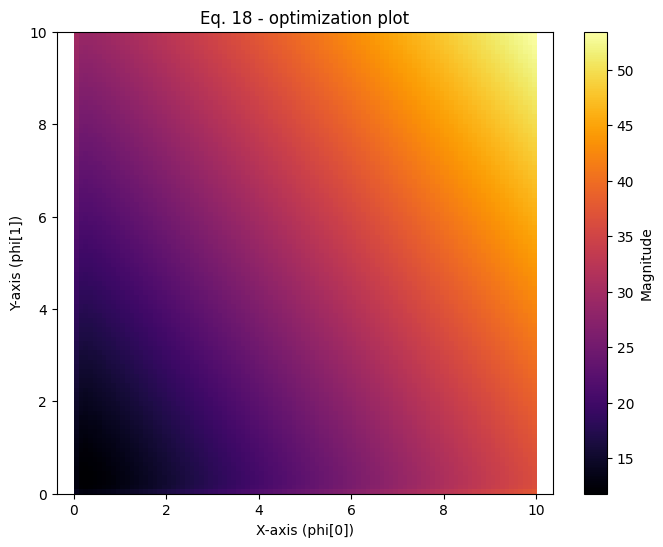

In [14]:
D_KL_search_space = np.linspace(0.01, 10, 100)

# Use parallel processing to speed up the nested loop
results = []
for i in D_KL_search_space:
    for j in D_KL_search_space:
        result = mrblatcomp.D_KL(np.array([10.08, 10.11, i, j]), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=False)
        results.append(result)

# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

gridsize = 100

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(results).reshape(gridsize, gridsize)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, origin='lower', extent=[0, 10, 0, 10], cmap='inferno', aspect='auto')
#min_index = np.argmin(heatmap)
#min_index_2d = np.unravel_index(min_index, heatmap.shape)
#plt.scatter(min_index_2d[1]/gridsize, min_index_2d[0]/gridsize, marker='x', color='red', s=100)
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [15]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)

print(f"Minimum value at index: {min_index_2d}")

np.min(heatmap)

Minimum value at index: (np.int64(2), np.int64(2))


np.float64(11.777371309770665)

In [16]:
gridsize = 100

# Define the range for phi[0] and phi[1]
x_values = np.linspace(0.0001, 50.0001, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(0.0001, 50.0001, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [1],  [1]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (10000, 4, 1)


In [17]:
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(mrblatcomp.D_KL(phis[n][:4].flatten(), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=False))

100%|██████████| 10000/10000 [00:17<00:00, 555.82it/s]


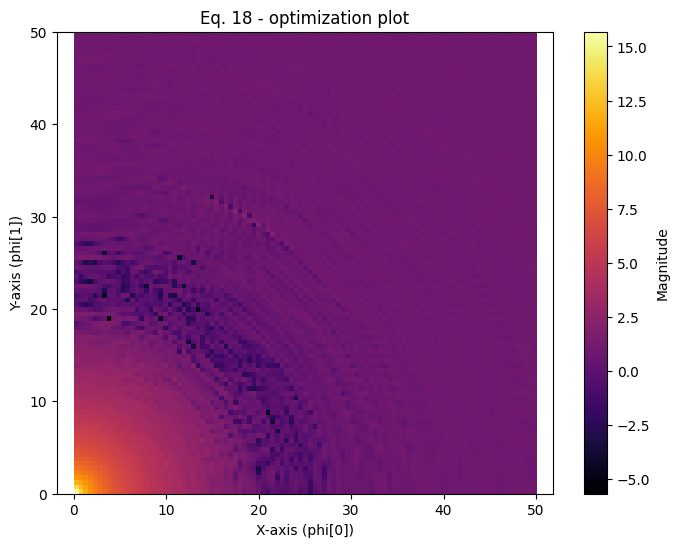

In [18]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.log(np.abs(heatmap[1:,1:])), origin='lower', extent=[0, 50, 0, 50], cmap='inferno')#, aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [19]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")
np.min(heatmap)

Minimum value at index: (np.int64(60), np.int64(37))
x: 18.68696868686869, y: 30.303130303030304


np.float64(-9.696176913126155)

In [20]:
delta_t = 0.1

T = np.array([[1, 0, delta_t, 0],
            [0, 1, 0, delta_t],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

T_inv = np.linalg.inv(T)

mu_a = np.array([[0],
                [0],
                [0],
                [0]])

G = np.diagflat([(delta_t**2)/2,(delta_t**2)/2,delta_t,delta_t])

G_inv = np.linalg.inv(G)

phi = np.array([[10],
                    [10],
                    [0],
                    [0]])

bound = [(-100,100), (0.1,100), (0.00001, 10), (0.00001, 10)]

In [21]:
def broadcast_parameters(n, phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_):
    """
    Each radar computes eps_bar and eps_barbar and broadcasts them.
    """
    # FOR LOOP HERE FOR MULTIPLE RADARS
    sim_data_all_virtual = sim_data[n,:,:,0,:].flatten()[:, np.newaxis]
    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

    result = minimize(mrblatcomp.D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), bounds = bound,  args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_, (1,1,1,1), False), method='nelder-mead')
    
    return result.x[np.newaxis].T


def message_passing(N_iter = 500, N = 20):
    eps_bar_list = []
    eps_barbar_list = []

    phi_bar_list = [np.array([[target_ground_truth[0][0]], [target_ground_truth[1][0]], [target_ground_truth[2][0]], [target_ground_truth[3][0]]])]
    phi_barbar_list = [np.array([[0.5,0,0,0], [0,0.5,0,0], [0,0,0.5,0], [0,0,0,0.5]])]

    # Initialze the Lambda a matrix
    Lambda_a = np.eye((4))*0.15

    fifo = 1

    for n in tqdm(range(N)):
        D_KL_res = broadcast_parameters(n+1, phi_bar_list[n][0, 0], phi_bar_list[n][1, 0], phi_barbar_list[n][0, 0], phi_barbar_list[n][1, 1])
        eps_bar = D_KL_res[:2]
        eps_bar = np.vstack((eps_bar, np.array([[0.], [0.]])))
        eps_bar_list.append(eps_bar)
        eps_barbar_list.append(np.array([[D_KL_res[2][0],0], [0,D_KL_res[3][0]]]))

        N = len(phi_bar_list)

        for _ in range(N_iter):
            for i in range(N): #N-fifo, N):
                eps_barbar_inv_extended = np.zeros((4,4))
                eps_barbar_inv_extended[:2, :2] = np.linalg.pinv(eps_barbar_list[i])
                if N - i == 1:
                    phi_bar_bar_inv = eps_barbar_inv_extended + G_inv.T@Lambda_a@G
                    phi_bar_bar = np.linalg.pinv(phi_bar_bar_inv)
                    phi_bar = phi_bar_bar @ eps_barbar_inv_extended @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i]
                else:
                    phi_bar_bar_inv = eps_barbar_inv_extended + G_inv.T@Lambda_a@G + T.T@G_inv.T@Lambda_a@G_inv@T
                    phi_bar_bar = np.linalg.pinv(phi_bar_bar_inv)
                    phi_bar = phi_bar_bar @ eps_barbar_inv_extended @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i] + (T.T@G_inv.T@Lambda_a@G_inv@T)@T_inv@phi_bar_list[i+1]
            if N >= 1:
                alpha = N+1
                beta = np.zeros((4,4))
                for i in range(N): #N-fifo, N):
                    beta += np.linalg.norm(G_inv@(phi_bar-T@phi_bar_list[i]))**2 + G_inv@(phi_bar_bar+T@phi_barbar_list[i]@T.T)@G_inv.T
                Lambda_a = np.linalg.pinv(beta/alpha)
        
        phi_bar_list.append(phi_bar)
        phi_barbar_list.append(phi_bar_bar)
        if fifo < 20:
            fifo += 1


    return phi_bar_list, phi_barbar_list

In [22]:
mrblat_data, mrblat_data_phibarbar= message_passing()
mrblat_data

  5%|▌         | 1/20 [00:00<00:13,  1.41it/s]C:\Users\malth\AppData\Local\Temp\ipykernel_2220\320537804.py:16: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(mrblatcomp.D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), bounds = bound,  args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_, (1,1,1,1), False), method='nelder-mead')
100%|██████████| 20/20 [00:17<00:00,  1.12it/s]


[array([[10.001     ],
        [10.001     ],
        [ 0.99998333],
        [ 1.        ]]),
 array([[10.09454862],
        [10.11053642],
        [ 0.01226334],
        [ 0.0122647 ]]),
 array([[10.20303017],
        [10.2034833 ],
        [ 0.25401108],
        [ 0.25401942]]),
 array([[10.32360502],
        [10.28364127],
        [ 0.25782642],
        [ 0.25682395]]),
 array([[10.4284951 ],
        [10.38000322],
        [ 0.26136265],
        [ 0.26014942]]),
 array([[10.51591723],
        [10.48883773],
        [ 0.2645696 ],
        [ 0.2639155 ]]),
 array([[10.63015116],
        [10.57716325],
        [ 0.26624717],
        [ 0.26497576]]),
 array([[10.724655  ],
        [10.68223676],
        [ 0.26831266],
        [ 0.26726285]]),
 array([[10.80446283],
        [10.7961033 ],
        [ 0.27000449],
        [ 0.27030856]]),
 array([[10.92199127],
        [10.88434308],
        [ 0.27318536],
        [ 0.27224397]]),
 array([[11.02486029],
        [10.98029443],
        [ 0.27

In [23]:
%prun message_passing()

  5%|▌         | 1/20 [00:00<00:15,  1.26it/s]C:\Users\malth\AppData\Local\Temp\ipykernel_2220\320537804.py:16: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(mrblatcomp.D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), bounds = bound,  args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_, (1,1,1,1), False), method='nelder-mead')
100%|██████████| 20/20 [00:21<00:00,  1.07s/it]

         17577839 function calls in 21.419 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    4.420    4.420   21.419   21.419 320537804.py:21(message_passing)
     7056    2.749    0.000    3.520    0.000 fmcwRadar.py:183(generate_S_signal)
   220000    2.602    0.000    9.391    0.000 _linalg.py:2106(pinv)
   220000    2.453    0.000    4.007    0.000 _linalg.py:1613(svd)
     7056    0.819    0.000    0.819    0.000 mrblatFunctions.py:112(partial_sinc)
   231067    0.566    0.000    0.566    0.000 {method 'reduce' of 'numpy.ufunc' objects}
   281400    0.523    0.000    0.906    0.000 _linalg.py:2566(norm)
   220000    0.477    0.000    0.477    0.000 _linalg.py:3186(matmul)
     3528    0.335    0.000    6.970    0.002 mrblatFunctions.py:128(D_KL)
    10584    0.309    0.000    0.309    0.000 mrblatFunctions.py:102(sinc)
   221986    0.287    0.000    0.955    0.000 fromnumeric.py:69(_wrapreduction)
     3528 

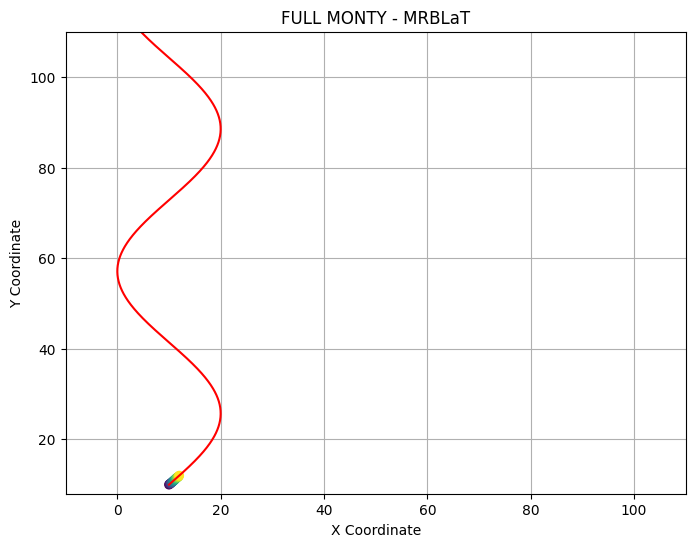

In [ ]:
# Extract the first two indices from mrbalt_data
x_coords = [data[0, 0] for data in mrblat_data]
y_coords = [data[1, 0] for data in mrblat_data]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords,c=np.linspace(0, 1, len(x_coords)), cmap='viridis', marker='o')
plt.plot(target_ground_truth[0], target_ground_truth[1], c='red')
plt.xlim([-10, 110])
plt.ylim([8, 110])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('FULL MONTY - MRBLaT')
plt.grid(True)
plt.show()

In [ ]:
mrblat_data

[array([[10.001     ],
        [10.001     ],
        [ 0.99998333],
        [ 1.        ]]),
 array([[10.09454862],
        [10.11053642],
        [ 0.01226334],
        [ 0.0122647 ]]),
 array([[10.20303017],
        [10.2034833 ],
        [ 0.25401108],
        [ 0.25401942]]),
 array([[10.32360502],
        [10.28364127],
        [ 0.25782642],
        [ 0.25682395]]),
 array([[10.4284951 ],
        [10.38000322],
        [ 0.26136265],
        [ 0.26014942]]),
 array([[10.51591723],
        [10.48883773],
        [ 0.2645696 ],
        [ 0.2639155 ]]),
 array([[10.63015116],
        [10.57716325],
        [ 0.26624717],
        [ 0.26497576]]),
 array([[10.724655  ],
        [10.68223676],
        [ 0.26831266],
        [ 0.26726285]]),
 array([[10.80446283],
        [10.7961033 ],
        [ 0.27000449],
        [ 0.27030856]]),
 array([[10.92199127],
        [10.88434308],
        [ 0.27318536],
        [ 0.27224397]]),
 array([[11.02486029],
        [10.98029443],
        [ 0.27

: 

In [ ]:
results = np.zeros((1000, 4))

results[0] = np.array(([10, 10, 1, 1]))  # Initialize results as a list of lists

for n in tqdm(range(999)):

    sim_data_all_virtual = sim_data[n+1,:,:,0,:]
    sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T
    
    result = minimize(mrblatcomp.D_KL, (results[n][0], results[n][1], results[n][2], results[n][3]), bounds = bound,  args=(data_fourier, results[n][0], results[n][1], (1,1,1,1), False), method='nelder-mead')

    results[n+1] = result.x.tolist()  # Insert the result at the correct index

 12%|█▏        | 117/999 [00:32<05:11,  2.83it/s]

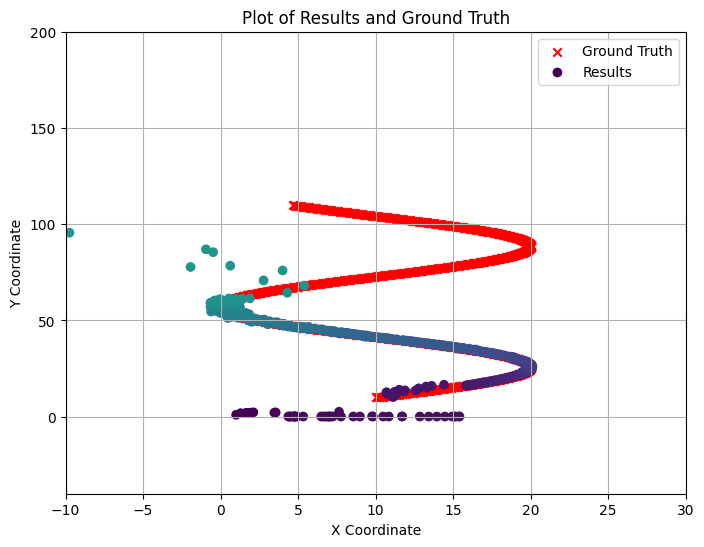

In [ ]:
# Extract the first two indices from results
x_results = [result[0] for result in results]
y_results = [result[1] for result in results]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x', label='Ground Truth')
plt.scatter(x_results, y_results, c=np.linspace(0, 1, len(x_results)), cmap='viridis', marker='o', label='Results')

#plt.scatter(eq18[0][0], eq18[1][0], c='green', marker='x', label='Eq. 18')
plt.xlim([-10, 30])
plt.ylim([-40, 200])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of Results and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()